# Plots Used in Paper

Paper citation: (!TODO)

These are the plots used in the above paper. Data is available on Zenodo.

Contact the author for more information or with questions.


In [1]:
import xarray as xr
import sys
sys.path.append('../../')
from utility_programs.read_routines import SAMI, GITM
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

from matplotlib.dates import DateFormatter
import numpy as np
import datetime
import os
import pandas as pd
import gc
import importlib
from utility_programs import filters
from utility_programs import plotting_routines
import paperfigures

In [2]:
plotting_routines = importlib.reload(plotting_routines)

In [3]:
simstorm_datadir = '/glade/scratch/abukowski/postprocessed/'


In [4]:
samids = xr.open_mfdataset(simstorm_datadir +'may_storm-on_full_LND_SAMI_REGRID.nc', engine = 'h5netcdf')
gitmds = xr.open_mfdataset(simstorm_datadir +'may_full_ut12_storm-on_GITM.nc', engine = 'h5netcdf')

storm_start = pd.Timestamp(2011, 5, 21, 12)

In [5]:
samids.alt.max()

<xarray.DataArray 'alt' ()>
array(2125)

In [6]:
def timedeltatotime(td, secs_back=False):
    td_in_seconds = td.total_seconds()
    hours, remainder = divmod(td_in_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    hours = int(hours)
    minutes = int(minutes)
    seconds = int(seconds)
    
    if hours <= -1:
        hours += 1
        if secs_back:
            tstring = '-%s:%s:%s' %(str(np.abs(hours)).rjust(2,'0'), str(minutes).rjust(2,'0'), str(seconds).rjust(2,'0'))
        else:
            tstring = '-%s:%s' %(str(np.abs(hours)).rjust(2,'0'), str(minutes).rjust(2,'0'))
    else:
        if secs_back:
            tstring = '%s:%s:%s' %(str(hours).rjust(2,'0'), str(minutes).rjust(2,'0'), str(seconds).rjust(2,'0'))
        else:
            tstring = '%s:%s' %(str(hours).rjust(2,'0'), str(minutes).rjust(2,'0'))
    
    return tstring

# Filters available:

In [7]:
from scipy.signal import butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt


def filt_filt(da,
              freq=5,
              lims=[40, 85],
              order=1,
              percent=True):

    # Define sampling frequency and limits in minutes
    sampling_freq = freq
    lower_limit = min(lims)
    upper_limit = max(lims)

    # Convert limits to corresponding indices
    lower_index = int(lower_limit / sampling_freq)
    upper_index = int(upper_limit / sampling_freq)

    # Design the bandpass filter
    nyquist_freq = 0.5 * sampling_freq
    lower_cutoff = lower_index / nyquist_freq
    upper_cutoff = upper_index / nyquist_freq
    b, a = butter(order, [1/upper_cutoff, 1/lower_cutoff],
                  btype='band', analog=False)

    # Apply the filter to the data
    filtd = filtfilt(b, a, da, axis=0)
    # filtd = xr.apply_ufunc(filtfilt, b, a, da, dask='allowed')

    if percent:
        return (100*(filtd)/da)

    else:
        da.values = filtd
        return da


def sos_filt_filt(da,
                  freq=5,
                  lims=[85, 40],
                  order=1,
                  percent=True):

    sample_freq = 5  # min

    lowcut_f = 1 / (max(lims) / (60/freq))   # 85 minutes in units of sample^-1
    highcut_f = 1 / (min(lims) / (60/freq))  # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * freq  # 5 minutes is the sampling frequency
    low = lowcut_f / nyquist
    high = highcut_f / nyquist
    sos = butter(order, [low, high], btype="bandstop", output="sos")

    filtd = sosfiltfilt(sos, da, axis=0)

    if percent:
        return 100*(da-filtd)/da

    else:
        da.values = filtd
        return da


def diffs(da,
          pts,
          percent):

    if percent:
        return 100*(da.diff('time', pts, label='lower')/da)
    else:
        return da.diff(dim, pts, label='lower')

In [8]:
mageq_df = pd.read_csv('/glade/u/home/abukowski/mag_equator.txt', sep=' ')
mageq_df

,glon,mlat
0,0,10.7
1,5,10.6
2,10,10.5
3,15,10.3
4,20,9.9
...,...,...
68,340,9.2
69,345,9.9
70,350,10.4
71,355,10.7


In [9]:
glons_new = [i if i <=180 else i-360 for i in mageq_df['glon']]
mlats_new = [i for i in mageq_df['mlat']]

# glons_new.append(row['glon'] if )

sorted_idxs = np.argsort(glons_new)

mageq_df2 = pd.DataFrame()
mageq_df2['glon'] = np.array(glons_new)[sorted_idxs]
mageq_df2['mlat'] = np.array(mlats_new)[sorted_idxs]



# mageq_df['glon'] 

In [10]:
mageq_df

,glon,mlat
0,0,10.7
1,5,10.6
2,10,10.5
3,15,10.3
4,20,9.9
...,...,...
68,340,9.2
69,345,9.9
70,350,10.4
71,355,10.7


# Settings

In [11]:
storm_start = pd.Timestamp(2011, 5, 21, 12)
plot_start = pd.Timestamp(2011, 5, 21, 12, 15)
plot_delta = pd.Timedelta('30 minutes')

numplots = 6

gitm_alt = 500
gitm_lons = [0, 60, 120, 180, 240, 300]

keo_tlims = [storm_start-pd.Timedelta('3 hours'), storm_start + pd.Timedelta('8 hours')]

vlims=6

col = 'Rho'
at_alt = 550

In [12]:
do_filter = filt_filt

# FIGURES

## 1

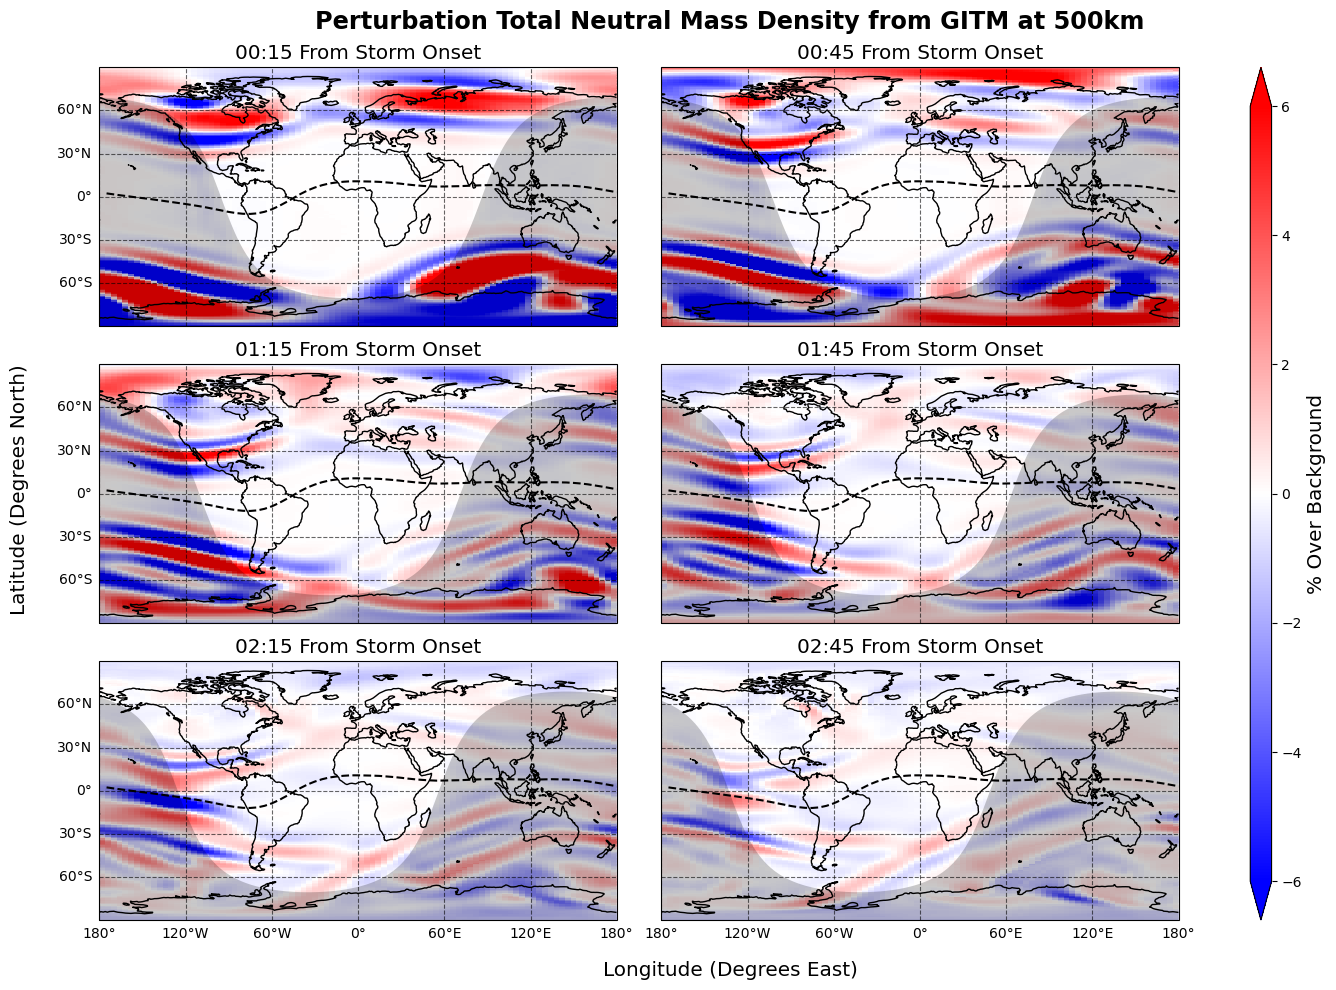

In [13]:
# map of gitm
paperfigures = importlib.reload(paperfigures)

figure1 = paperfigures.fig1(
    ds=do_filter(gitmds.Rho.sel(alt=gitm_alt, method='nearest')),
    vlims=vlims,
    plot_start=plot_start,
    plot_delta=plot_delta,
    storm_start=storm_start,
    at_alt=gitm_alt,
    mag_eq=mageq_df2,
)
figure1.show()

## 2

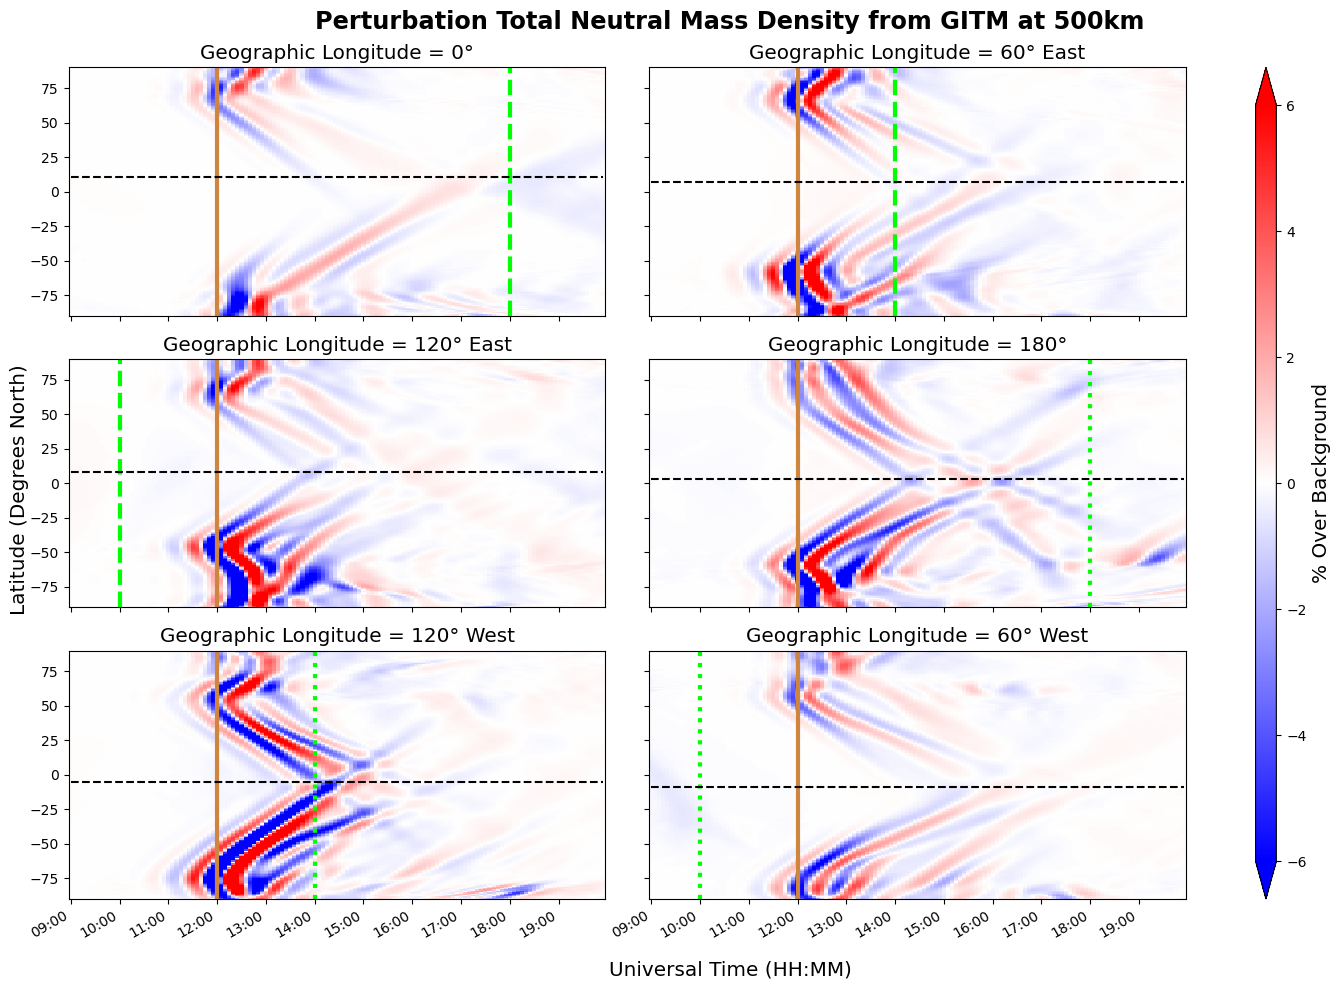

In [14]:
# gitm keo
paperfigures = importlib.reload(paperfigures)

figure2 = paperfigures.fig2(
    ds=do_filter(gitmds.Rho.sel(alt=gitm_alt,  method='nearest')),
    tlims=keo_tlims,
    vlims=vlims,
    at_alt=500,
    lons=gitm_lons,
    mag_eq=mageq_df,
)

figure2.show()

## 3

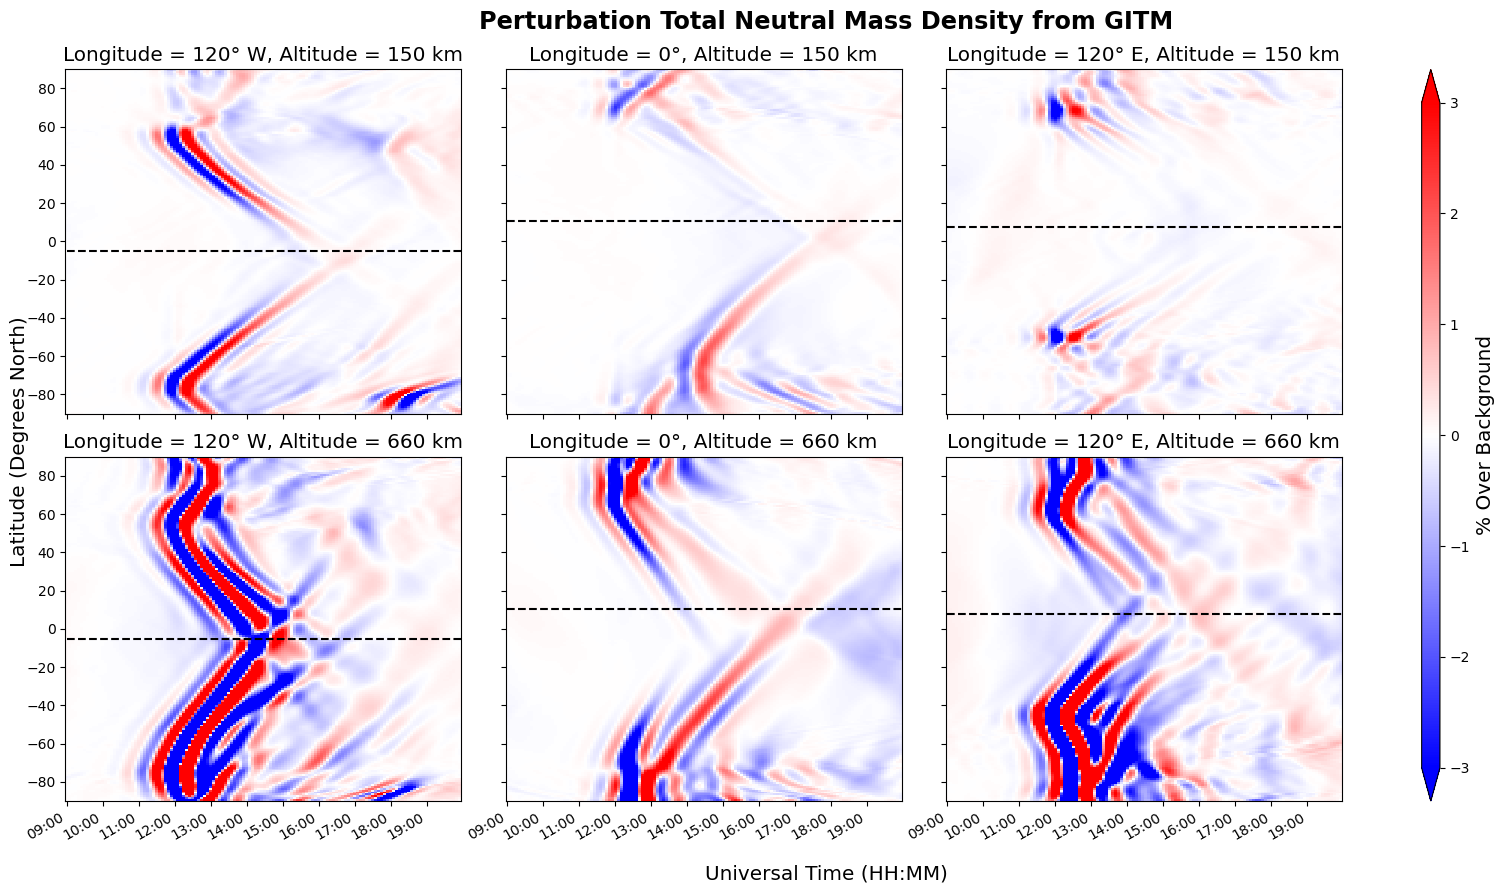

In [15]:
# gitm keo

plt.close('all')

newlon = [6, 120, 240]


fig, axs = plt.subplots(2, 3,figsize=(17, 9),
                            sharex=True,
                            sharey=True,)

axes = axs.flatten()


do_filter(gitmds.Rho.sel(lon=newlon[0], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=150, method='nearest').plot(
    ax=axes[1], x='time',robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[1].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[0]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')

do_filter(gitmds.Rho.sel(lon=newlon[1], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=150, method='nearest').plot(ax=axes[2], x='time', robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[2].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[1]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')

do_filter(gitmds.Rho.sel(lon=newlon[2], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=150, method='nearest').plot(ax=axes[0], x='time', robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[0].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[2]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')

do_filter(gitmds.Rho.sel(lon=newlon[0], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=660, method='nearest').plot(ax=axes[4], x='time', robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[4].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[0]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')

do_filter(gitmds.Rho.sel(lon=newlon[1], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=660, method='nearest').plot(ax=axes[5], x='time', robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[5].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[1]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')



im = do_filter(gitmds.Rho.sel(lon=newlon[2], method='nearest')).sel(time=slice(keo_tlims[0], keo_tlims[1])).sel(alt=660, method='nearest').plot(ax=axes[3], x='time', robust=True, cmap='bwr', vmin=-3, vmax=3, add_colorbar=False,)
axes[3].hlines(mageq_df['mlat'][np.argmin(np.abs(mageq_df['glon'] - newlon[2]))],
                keo_tlims[0], keo_tlims[1], linestyle='--', color='k')




axes[1].set_title("Longitude = 0°, Altitude = 150 km", fontsize='x-large')
axes[2].set_title("Longitude = 120° E, Altitude = 150 km", fontsize='x-large')
axes[0].set_title("Longitude = 120° W, Altitude = 150 km", fontsize='x-large')

axes[4].set_title("Longitude = 0°, Altitude = 660 km", fontsize='x-large')
axes[5].set_title("Longitude = 120° E, Altitude = 660 km", fontsize='x-large')
axes[3].set_title("Longitude = 120° W, Altitude = 660 km", fontsize='x-large')


for ax in axes:
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.supxlabel('Universal Time (HH:MM)', fontsize='x-large')
fig.supylabel('Latitude (Degrees North)', fontsize='x-large')
    
fig.suptitle('Perturbation Total Neutral Mass Density from GITM',
                 fontsize='xx-large', fontweight='heavy')   
    
fig.tight_layout()    



cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="vertical",
                        aspect=40, extend='both',)
cbar.set_label('% Over Background', fontsize='x-large')


fig.show()

## 4

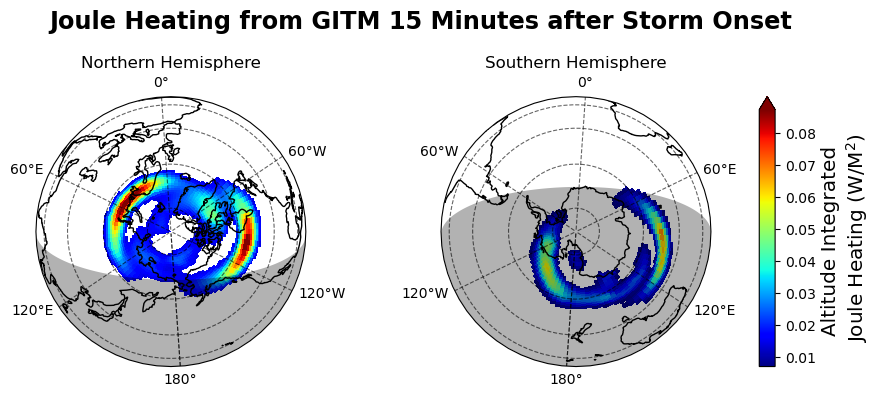

In [16]:
# JH dials
paperfigures = importlib.reload(paperfigures)

figure3 = paperfigures.fig3(
    gitmds.AltIntJouleHeating_W_m2.where(gitmds.AltIntJouleHeating_W_m2 > 0.007).sel(
        time=storm_start+pd.Timedelta('15 minutes'), method='nearest'),
    vmin=0.0,
    vmax=.08,
    suptitle='Joule Heating from GITM 15 Minutes after Storm Onset')
figure3.show()

## 5

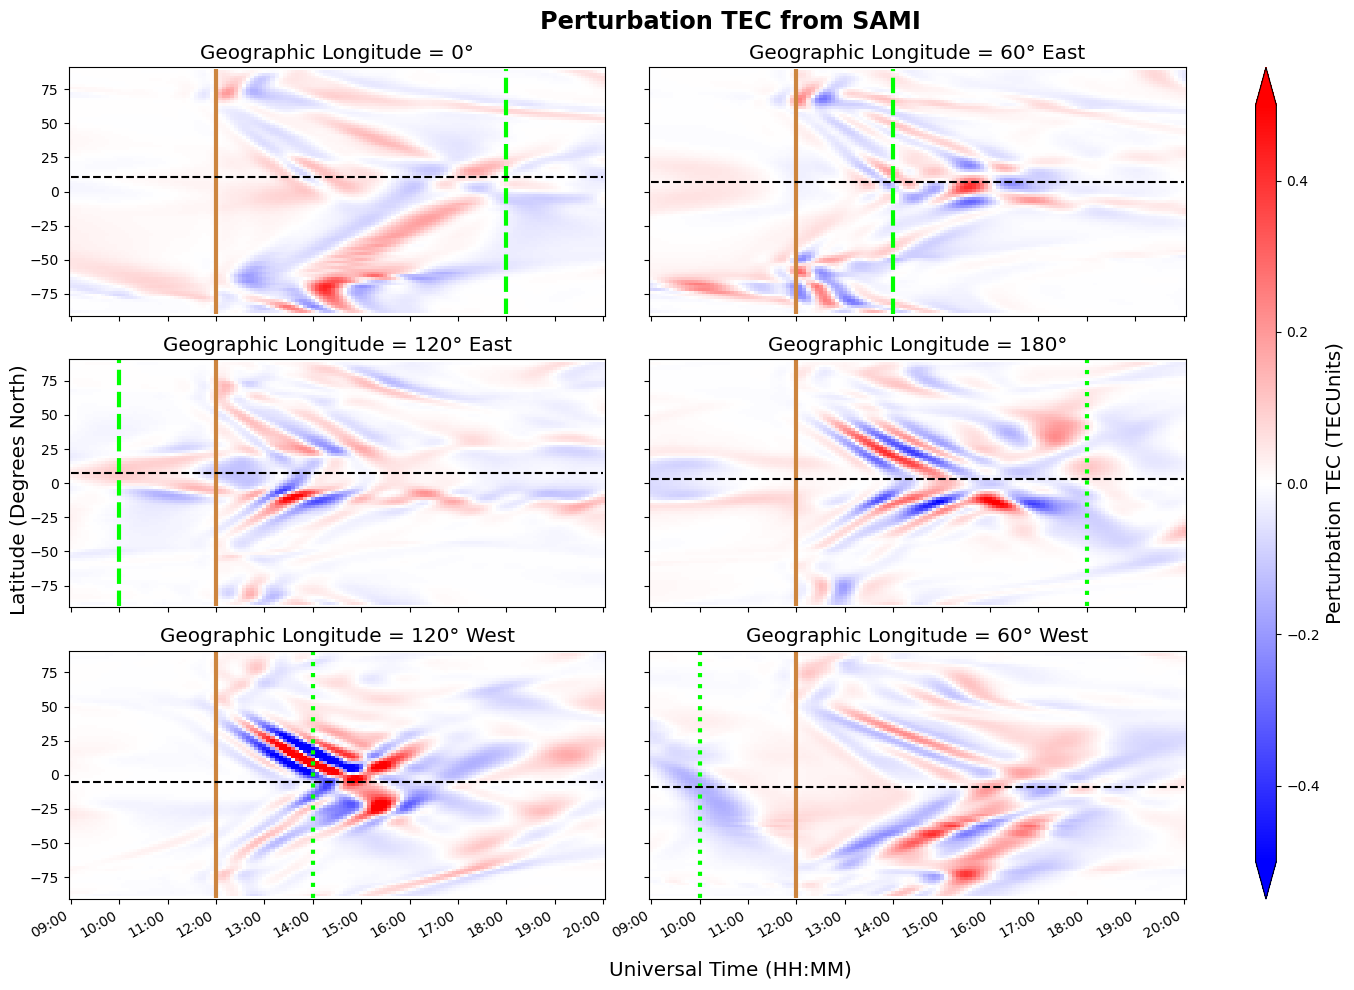

In [17]:
# sami keos
paperfigures = importlib.reload(paperfigures)

figure4 = paperfigures.fig4(
    ds=do_filter(samids.edens.integrate('alt'), percent=False)/1e7,
    tlims=keo_tlims,
    vlims=.5,
    lons=gitm_lons,
    mag_eq=mageq_df,
)
figure4.show()

## Not TEC UNITS!!!

## 6

/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/abukowski/conda-envs/SAMI3-GITM/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


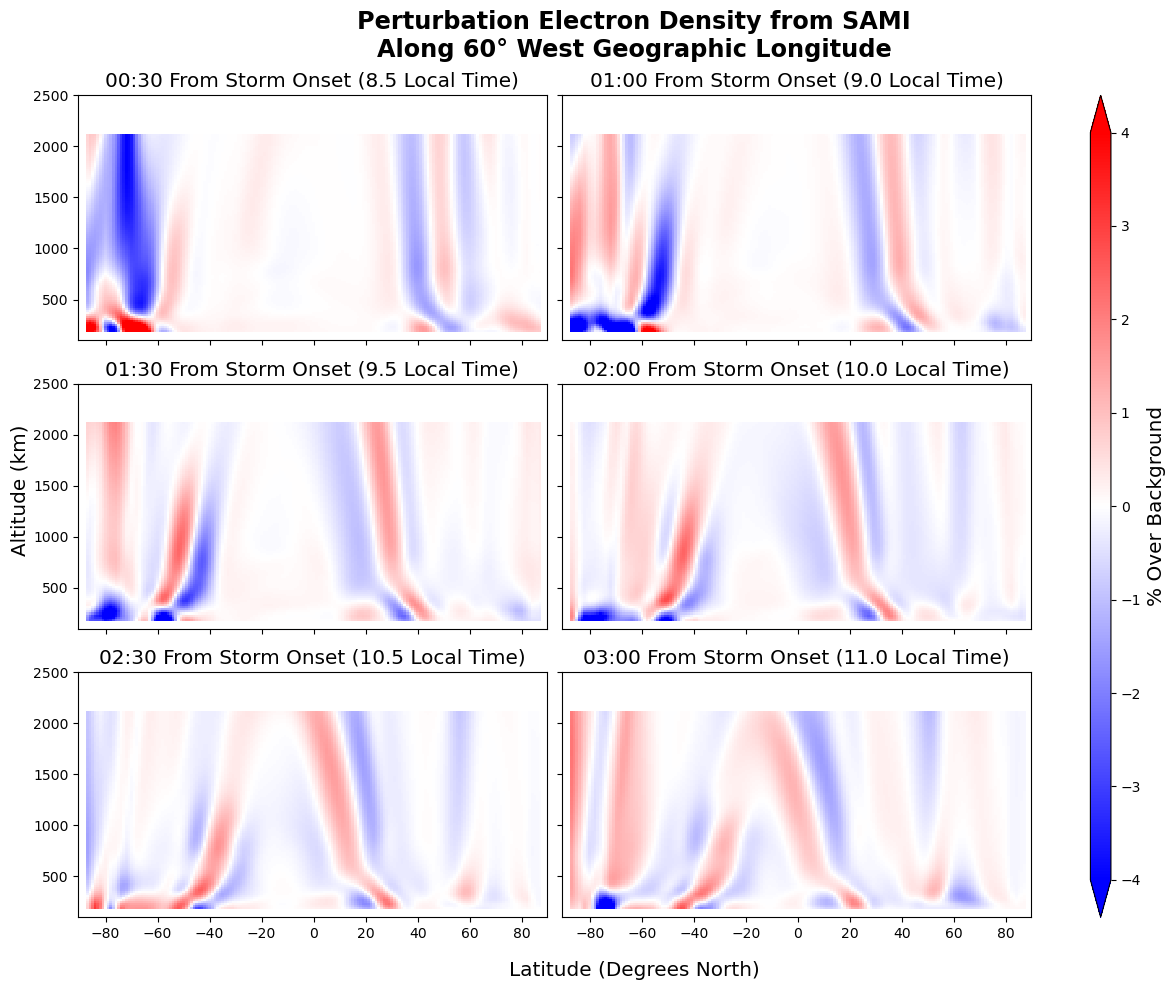

In [18]:
paperfigures = importlib.reload(paperfigures)

figure5 = paperfigures.fig5(
    ds=do_filter(samids.edens.sel(lon=300, method='nearest')),
    vlims=4,
    lon=300,
    max_alt=2500,
    storm_start=storm_start,
    times=[pd.Timestamp('2011-05-21 12:30') + i*pd.Timedelta('30 minutes') for i in range(6)],
)
figure5.show()